In [1612]:
#import required libraries
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset, WeightedRandomSampler
from torchvision import transforms
import pytorch_lightning as pl
from torchmetrics import Accuracy
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Setting seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class FixedSeedTransform:
    def __init__(self, transform, seed=42):
        self.transform = transform
        self.seed = seed

    def __call__(self, x):
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        return self.transform(x)

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.labels_df.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert("RGB")
        label = self.labels_df.iloc[idx, 1]
        patient_id = self.labels_df.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label, patient_id


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


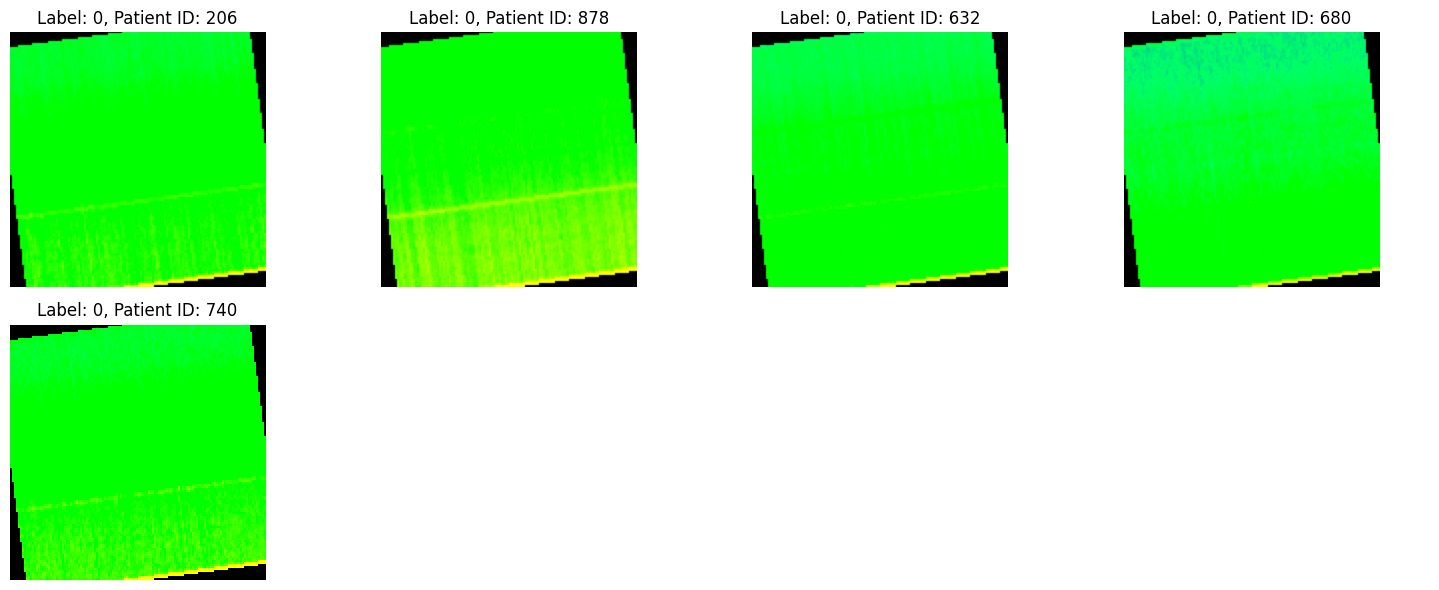

In [1613]:
# Define transformations for the images with a fixed random seed
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize based on ImageNet
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
    FixedSeedTransform(transforms.RandomHorizontalFlip(p=0.5)),  # Add data augmentation with fixed seed
    FixedSeedTransform(transforms.RandomRotation(10)),  # Add data augmentation with fixed seed
    

])

dataset = CustomImageDataset(csv_file='image/label.csv', img_dir='image/all', transform=transform)



# Fetch the first 5 images and their labels
first_5_images_labels = [dataset[i] for i in range(5)]
# [{image,0,206}, {image, 0, 878}, ... ]

# Display in a grid
rows = 2  # Number of rows in the grid
cols = 4  # Number of columns in the grid

# Calculate the number of images to display (ensure it's within the available images)
num_images_to_display = min(len(first_5_images_labels), rows * cols)


# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Adjust figsize for grid size


for i, ax in enumerate(axes.flat):
    if i < num_images_to_display:
        image, label, patient_id = first_5_images_labels[i]

        # Ensure image is in correct format (H, W, C) and in range [0, 1] for display



        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f'Label: {label}, Patient ID: {patient_id}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots if you have fewer than rows * cols images

plt.tight_layout()
plt.show()

In [1614]:
X = np.array([sample[0] for sample in dataset])
y = np.array([sample[1] for sample in dataset])
print(X.shape)


(246, 3, 128, 128)


In [1615]:

print(X.shape)

# patient_ids = np.array([sample[2] for sample in dataset])
print(y)
print(y.shape)
print(np.count_nonzero(y==1))
print(np.count_nonzero(y==0))



(246, 3, 128, 128)
[0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(246,)
51
195


In [1616]:
# Convert X and y to PyTorch tensors if they are not already
X = torch.tensor(X).float()
y = torch.tensor(y).long()  # Use long type for labels



# Create a TensorDataset
dataset = TensorDataset(X, y)



In [1617]:
import torch.nn as nn
import torch.nn.functional as F


class ParallelCNN(nn.Module):
    def __init__(self, num_classes=1):  
        super(ParallelCNN, self).__init__()

        # Branch 1 (filter size 1)
        self.conv_branch1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1, padding=0), # Assuming input channels = 3 (RGB)
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling to ensure same output size
        )

        # Branch 2 (filter size 2)
        self.conv_branch2 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # Adaptive pooling to ensure same output size
        )

        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4 * 2, 512),  # Adjusted input size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output for your number of classes
        )

    def forward(self, x):
        out1 = self.conv_branch1(x)
        out2 = self.conv_branch2(x)
        out = torch.cat([out1, out2], dim=1)  # Concatenate along the channel dimension
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out




In [1618]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return torch.mean(F_loss)

In [1619]:
from torch.optim import Adam

 ##Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience = 3):

    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0
    patience_counter = 0
   
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
  
        val_loss = 0.0


        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item() * images.size(0)

  

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)


        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        #Check model output statistics
        with torch.no_grad():
            sample_outputs = model(images)
            print(f'Sample outputs: {torch.sigmoid(sample_outputs).cpu().numpy().flatten()[:5]}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()  # Save model state
            best_epoch = epoch
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss")
                break  # Exit early stopping if no improvement

    # Use best model for final validation or testing
    model.load_state_dict(best_model)  # Load best model state  

    return best_model    
 



In [1620]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[:2]
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten()
            print(f'Predicted outputs: {preds}')
            y_pred.extend(preds>0.5)
            y_true.extend(labels.cpu().numpy().flatten())
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item() * images.size(0)
   
    y_pred = np.round(y_pred).astype(int)

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    return y_true, y_pred



In [1621]:
# Aggregate the results
def aggregate_results(reports):
    avg_report = {}
    for key in reports[0].keys():
        if isinstance(reports[0][key], dict):
            avg_report[key] = {}

            for sub_key in reports[0][key].keys():
                 # Collect all non-zero values for the current metric
                non_zero_values = [report[key][sub_key] for report in reports if report[key][sub_key] != 0]
                if non_zero_values:
                    if sub_key == 'support':
                        avg_report[key][sub_key] =  sum(non_zero_values)
                    elif sub_key == 'accuracy':
                        avg_report[key][sub_key] =  sum(non_zero_values) / len(non_zero_values)
                    else :
                        avg_report[key][sub_key] = np.amax(non_zero_values) 
        else: 
            if key == 'support':
                avg_report[key] = np.sum([report[key] for report in reports])
            elif key == 'accuracy':
                avg_report[key] = np.mean([report[key] for report in reports])
            else:
                avg_report[key] = np.mean([report[key] for report in reports])

    
                    
    return avg_report

In [1622]:
def sampler_generator(dataset):
    # Get the class distribution for the dataset
    labels = [label.item() for _, label in dataset]
    class_counts = np.bincount(labels)
    # Ensure there are no zero counts to avoid division by zero
    class_counts = np.clip(class_counts, 1, None)

    # Calculate the class weights inversely proportional to class frequencies
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    class_weights /= class_weights.sum()  # Normalize the weights

    # Apply weights to samples based on their labels
    samples_weights = np.array([class_weights[label] for label in labels])
    return WeightedRandomSampler(samples_weights, len(samples_weights))

In [1623]:
def compute_class_weights(y):
    class_counts = torch.bincount(y)
    class_weights = 1. / class_counts.float()
    return class_weights

In [1624]:
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import StepLR

def run_experiment():


    reports = []
    all_y_true = []
    all_y_pred = []

    for train_val_indices, test_indices in StratifiedKFold(n_splits=2, shuffle=True, random_state=42).split(X, y):
            train_val_X, test_X  = X[train_val_indices], X[test_indices], 
            train_val_y, test_y = y[train_val_indices], y[test_indices]
            # Inner Stratified KFold for train-val split
            inner_skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
            for train_indices, val_indices in inner_skf.split(train_val_X, train_val_y):
                train_X, val_X = train_val_X[train_indices], train_val_X[val_indices]
                train_y, val_y = train_val_y[train_indices], train_val_y[val_indices]

        
                


                train_X_flattened = train_X.reshape(train_X.shape[0], -1) 

       
                adasyn = ADASYN(sampling_strategy='minority', random_state=42)
                train_rs_X, train_rs_y = adasyn.fit_resample(train_X_flattened, train_y)

                train_rs_X = train_rs_X.reshape(train_rs_X.shape[0], 3, 128, 128)


                train_rs_X = torch.tensor(train_rs_X).float()
                train_rs_y = torch.tensor(train_rs_y).long()  # Use long type for labels


                train_dataset = TensorDataset(train_rs_X,train_rs_y )
                val_dataset = TensorDataset(val_X, val_y )
                test_dataset = TensorDataset(test_X, test_y )

                #print(train_rs_y)

                train_subset = Subset(dataset, train_indices)
                val_subset = Subset(dataset, val_indices)
                test_subset = Subset(dataset, test_indices)

                train_sampler = sampler_generator(train_subset)
                val_sampler = sampler_generator(val_subset)
                test_sampler = sampler_generator(test_subset)



                # Create DataLoaders for each subset
                batch_size = 32
                train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False )
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                # Define model, criterion, optimizer
                model = ParallelCNN()
                criterion = FocalLoss(alpha=0.75, gamma=2)
            
                optimizer = Adam(model.parameters(), lr=0.001)  # Adjusted learning rate
                scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decrease learning rate by a factor of 0.1 every 5 epochs

                # Train the model
                num_epochs = 10
                best_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,  num_epochs)

                model.load_state_dict(best_model)

                # Test the model
                y_true, y_pred = test_model(model, test_loader, criterion)
                report = classification_report(y_true, y_pred, output_dict=True)

                reports.append(report)
                all_y_true.append(y_true)
                all_y_pred.append(y_pred)

    return all_y_true, all_y_pred, reports

        
           

In [1625]:
# Function to compute a combined metric of precision and recall for both labels
def combined_metric(label, report):
    return (report[label]['precision'] + report[label]['recall'] ) / 2

In [1626]:
def run_optimization():

    # Initialize variables to store the best results for each label
    best_report_label_0 = None
    best_report_label_1 = None
    best_y_pred = None
    y_true = None ##There is no best y_true->All true labels are the same every time
    best_metric_value_label_0 = -1
    best_metric_value_label_1 = -1
    last_updated_report0_index = 0
    last_updated_report1_index = 0

    all_y_true, all_y_pred, reports = run_experiment()

    for i in range(len(reports)):
        
        report = reports[i]

        
        metric_value_label_0 = combined_metric('0', report)
        metric_value_label_1 = combined_metric('1', report)

        
        if metric_value_label_0 > best_metric_value_label_0:
            best_metric_value_label_0 = metric_value_label_0
            best_report_label_0 = report
            last_updated_report0_index = i

            
        if metric_value_label_1 > best_metric_value_label_1:
            best_metric_value_label_1 = metric_value_label_1
            best_report_label_1 = report
            last_updated_report1_index = i

    # Combine the best reports into one
    combined_report = best_report_label_0.copy()
    combined_report['1'] = best_report_label_1['1']


    best_y_pred = all_y_pred[last_updated_report1_index]
    y_true = all_y_true[0]

    return y_true, best_y_pred, combined_report



In [1627]:
def objective(trial):
    y_true, y_pred, report = run_optimization()
    f1_score_label_0 = report['0']['f1-score']
    f1_score_label_1 = report['1']['f1-score']

    # Store y_true and y_pred as user attributes
    trial.set_user_attr("y_true", y_true)
    trial.set_user_attr("y_pred", y_pred)

    return f1_score_label_0, f1_score_label_1

In [1628]:
import optuna

def run_optuna():
    study = optuna.create_study(directions=["maximize", "maximize"])
    
    # Optimize the objective function
    study.optimize(objective, n_trials=5)

    # Retrieve the best F1 scores for both labels
    best_trial = study.best_trials[0]  # Optuna returns a list of best trials in multi-objective optimization
    best_f1_label_0 = best_trial.values[0]
    best_f1_label_1 = best_trial.values[1]

    best_y_true = best_trial.user_attrs["y_true"]
    best_y_pred = best_trial.user_attrs["y_pred"]

    print(f"Best F1 score for label 0: {best_f1_label_0}")
    print(f"Best F1 score for label 1: {best_f1_label_1}")

    
    # Display the classification report for the best trial
    best_report = classification_report(best_y_true, best_y_pred)
    print("Best Classification Report:")
    print(best_report)

run_optuna()


[I 2024-08-09 00:36:36,521] A new study created in memory with name: no-name-1338de5f-b58f-4d3f-bfc0-e7257f462780


Epoch 1/10, Train Loss: 0.2591, Val Loss: 0.1474
Sample outputs: [0.24307388 0.26809317 0.24058627 0.26479632 0.27311403]
Epoch 2/10, Train Loss: 0.9747, Val Loss: 0.1161
Sample outputs: [0.35200056 0.37718657 0.34623522 0.3672053  0.37520316]
Epoch 3/10, Train Loss: 0.3194, Val Loss: 0.1444
Sample outputs: [0.5215786  0.52683777 0.52115256 0.5251359  0.52565193]
Epoch 4/10, Train Loss: 0.3916, Val Loss: 0.1407
Sample outputs: [0.5165399  0.519622   0.51624167 0.5186759  0.518445  ]
Epoch 5/10, Train Loss: 0.2083, Val Loss: 0.1367
Sample outputs: [0.50238323 0.50409675 0.5015731  0.50268096 0.5023388 ]
Early stopping at epoch 5 due to no improvement in validation loss
Predicted outputs: [0.18602407 0.50092864 0.38440403 0.4685769  0.41674325 0.4549941
 0.3307162  0.46302566 0.48232234 0.49330464 0.2478548  0.5012992
 0.50374997 0.5033988  0.50268734 0.5043175  0.50322604 0.5035354
 0.5020951  0.50374895 0.45967886 0.32568082 0.504503   0.5027543
 0.5009978  0.50353116 0.49884635 0.4920

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Epoch 1/10, Train Loss: 0.8465, Val Loss: 0.1078
Sample outputs: [0.44767627 0.4479375  0.44701055 0.4475875  0.44651303]
Epoch 2/10, Train Loss: 0.7044, Val Loss: 0.1781
Sample outputs: [0.5685829 0.5703771 0.5621841 0.5628658 0.5638525]
Epoch 3/10, Train Loss: 0.3264, Val Loss: 0.1016
Sample outputs: [0.41899365 0.42001858 0.42938483 0.428138   0.42543814]
Epoch 4/10, Train Loss: 0.1719, Val Loss: 0.0967
Sample outputs: [0.3776121  0.37860942 0.3929914  0.39090136 0.38742426]
Epoch 5/10, Train Loss: 0.1556, Val Loss: 0.0967
Sample outputs: [0.35410833 0.35631347 0.3719745  0.36971068 0.36501837]
Epoch 6/10, Train Loss: 0.1843, Val Loss: 0.0987
Sample outputs: [0.33021072 0.33329874 0.35143045 0.34871688 0.34247816]
Epoch 7/10, Train Loss: 0.1239, Val Loss: 0.1016
Sample outputs: [0.31045562 0.31467217 0.33625093 0.3328149  0.32441762]
Epoch 8/10, Train Loss: 0.1410, Val Loss: 0.1055
Sample outputs: [0.29122236 0.29681095 0.32194328 0.31792042 0.30714682]
Early stopping at epoch 8 due

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Predicted outputs: [0.29101625 0.2889193  0.29549366 0.2982187  0.30289164 0.28955802
 0.30002457 0.30851737 0.29736936 0.29851046 0.29647988 0.3028156
 0.30383268 0.29568058 0.2963552  0.29579693 0.3012561  0.2969287
 0.29626825 0.325965   0.29099903 0.29424918 0.29735845 0.31696138
 0.29669535 0.29638788 0.29904902]
Test Loss: 0.1111
Epoch 1/10, Train Loss: 0.6734, Val Loss: 0.1001
Sample outputs: [0.36858368 0.37076184 0.36904714 0.37045348 0.37085676]
Epoch 2/10, Train Loss: 0.5670, Val Loss: 0.1143
Sample outputs: [0.4648717  0.46574947 0.46585417 0.46583667 0.46536046]
Epoch 3/10, Train Loss: 0.1758, Val Loss: 0.1336
Sample outputs: [0.5067351  0.50418967 0.5065477  0.50374204 0.50287366]
Epoch 4/10, Train Loss: 0.1542, Val Loss: 0.1304
Sample outputs: [0.5023678  0.49762112 0.5019008  0.4963717  0.49489933]
Early stopping at epoch 4 due to no improvement in validation loss
Predicted outputs: [0.48876697 0.49841076 0.5032169  0.5033061  0.50424695 0.50413024
 0.50059956 0.504021 

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Epoch 1/10, Train Loss: 0.4914, Val Loss: 0.1016
Sample outputs: [0.34222785 0.37065703 0.34752873 0.33784407 0.34039015]
Epoch 2/10, Train Loss: 0.3827, Val Loss: 0.1740
Sample outputs: [0.57001275 0.5579496  0.5679195  0.57148546 0.5703754 ]
Epoch 3/10, Train Loss: 0.5914, Val Loss: 0.1535
Sample outputs: [0.5397184 0.5374455 0.5391184 0.5404299 0.5398356]
Epoch 4/10, Train Loss: 0.2992, Val Loss: 0.1452
Sample outputs: [0.5268164  0.52568936 0.5262613  0.5271561  0.52691156]
Early stopping at epoch 4 due to no improvement in validation loss
Predicted outputs: [0.5258391  0.5255546  0.5258133  0.5258324  0.5257746  0.5251134
 0.5274003  0.52549106 0.5258264  0.52573824 0.5253283  0.5251941
 0.5256198  0.5257051  0.52549267 0.52573603 0.52557516 0.52564734
 0.5256176  0.52573216 0.5253917  0.52548593 0.52575934 0.52638406
 0.525658   0.5255363  0.52528083 0.5261401  0.52541476 0.5266261
 0.5255028  0.5274279 ]
Predicted outputs: [0.52578706 0.5257826  0.5255843  0.52582616 0.5256065  

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Epoch 1/10, Train Loss: 0.3504, Val Loss: 0.1021
Sample outputs: [0.31649828 0.3174974  0.31672245 0.31776688 0.315087  ]
Epoch 2/10, Train Loss: 0.9051, Val Loss: 0.1116
Sample outputs: [0.45300514 0.4544203  0.47689095 0.47529593 0.4717628 ]
Epoch 3/10, Train Loss: 0.3965, Val Loss: 0.1560
Sample outputs: [0.5419307  0.5489368  0.52346295 0.52502817 0.5270363 ]
Epoch 4/10, Train Loss: 0.4374, Val Loss: 0.1503
Sample outputs: [0.53592753 0.5423816  0.52097106 0.52262545 0.52440196]
Early stopping at epoch 4 due to no improvement in validation loss
Predicted outputs: [0.5379282  0.5348781  0.53921306 0.5435179  0.53924584 0.53260225
 0.5153245  0.5371435  0.5390731  0.53890365 0.5339352  0.54176205
 0.54257816 0.53031236 0.5374551  0.54167455 0.53052    0.5388723
 0.53847444 0.53502077 0.54108405 0.5425978  0.5284807  0.5208599
 0.53172135 0.53020287 0.52948546 0.5225097  0.54048544 0.52058893
 0.53050125 0.5160518 ]
Predicted outputs: [0.5247409  0.5458493  0.53797483 0.53986394 0.541

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Predicted outputs: [0.53886914 0.5411667  0.53175414 0.5339308  0.541739   0.54379225
 0.54145265 0.52611804 0.54087716 0.5405482  0.53923535 0.54065084
 0.54217154 0.534798   0.5411081  0.5388249  0.5413326  0.5378666
 0.5388426  0.51878077 0.5389764  0.5448355  0.5380464  0.5411761
 0.53618914 0.54199487 0.5381884 ]
Test Loss: 0.1488
Best F1 Score: 0.348993288590604
Best Parameters: {}
Best Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.20      1.00      0.34        25

    accuracy                           0.20       123
   macro avg       0.10      0.50      0.17       123
weighted avg       0.04      0.20      0.07       123



c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Confusion Matrix:


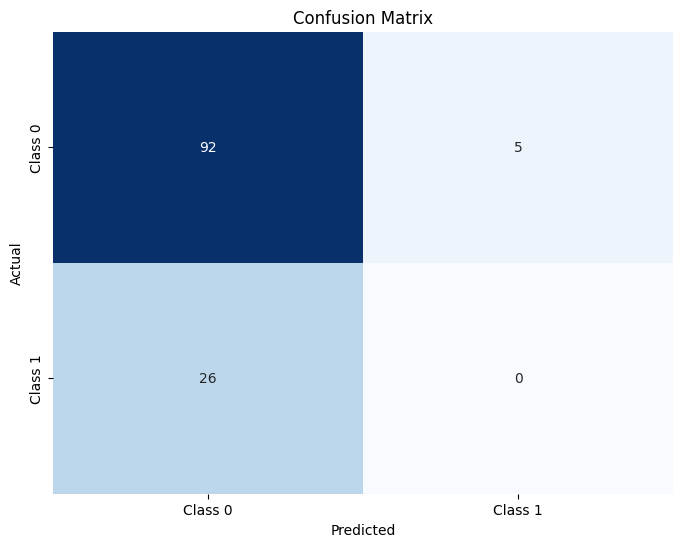

Test Accuracy: 0.7480
Best Classification Report for Label 0 and Label 1:
{'0': {'precision': 0.7886178861788617, 'recall': 1.0, 'f1-score': 0.8818181818181818, 'support': 97}, '1': {'precision': 0.19444444444444445, 'recall': 0.56, 'f1-score': 0.288659793814433, 'support': 25}, 'accuracy': 0.7886178861788617, 'macro avg': {'precision': 0.3943089430894309, 'recall': 0.5, 'f1-score': 0.4409090909090909, 'support': 123}, 'weighted avg': {'precision': 0.6219181704012161, 'recall': 0.7886178861788617, 'f1-score': 0.6954175905395418, 'support': 123}}


In [1629]:
# Visualize the confusion matrix for the best results
print("Confusion Matrix:")
cm = confusion_matrix(y_true, best_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the accuracy for the best results
accuracy = accuracy_score(y_true, best_y_pred)
print(f'Test Accuracy: {accuracy:.4f}')


# Print the best classification report
print("Best Classification Report for Label 0 and Label 1:")
print(combined_report)



